In [1]:
%matplotlib inline    
import matplotlib as mplt
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
# matplotlib.style.use('ggplot')


import statsmodels as sm
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import VAR, DynamicVAR

from statsmodels.stats import diagnostic


from utils_libs import *
from utils_data_prep import *
from mixture import *

/home/guo/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
1-12 months

each month: rmse, mape, mixture weight distribution, temporal and variate parameter distribution, 

In [2]:
# ---- overall error evaluation ----

def eval_mape(df):
    
    diff = df['truth'] - df['pre']
    tmp = (abs(diff)/(df['truth']+1e-10))

    tmpsum = []
    for i in range(len(tmp)):
        if abs(df['truth'].iloc[i])>1e-5:
            tmpsum.append( tmp[i] )
                    
    return mean(tmpsum)

def eval_rmse(df):
    return sqrt(mean((df['truth']-df['pre'])**2))
    
# ---- MAPE
# ---- RMSE
# ---- ACCURACY

col_format_mix = ['truth', 'pre', 'pre_v', 'pre_b']
col_format_gate = ['vol', 'ob']
col_format = ['truth', 'pre']

features_ob = [ 'spread', 'weightd spread', 'ask vol.', 'bid vol.', 'vol. diff.', 'ask depth', 'bid depth', \
               'depth diff.', 'bid slope', 'ask slope']

models = ['gbt', 'rf', 'xgt', 'bayes', 'gp', 'enet', 'ridge']
# 'arima', arimax', 'lasso', 'str', 'strx', 'garch', 'egarch'

file_path = "../bt_results/res/rolling/"

time_interval = 0

pre_ts = 'pytest_'
pre_tr = 'pytrain_'

gate_ts = 'gate_test'
gate_tr = 'gate_train'

post_txt = '.txt'
post_dat = '.dat'

weight_pre = '_weight_pre'
weight_gate = '_weight_gate'


In [3]:
print 'RMSE'
# RMSE
for i in range(2,14):
    
    tmp_rmse = []
    
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    tmp_rmse.append( eval_rmse(df) )
    
    for tmp_mdl in models:
        
        file_name = str(i) + '_' + pre_ts + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        tmp_rmse.append( eval_rmse(df) )
        
    print 'interval ', i, ': ', tmp_rmse
    

print 'MAPE'
# MAPE
for i in range(2,14):
    
    tmp_rmse = []
    tmp_mape = []
    
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    tmp_mape.append( eval_mape(df) )
    
    for tmp_mdl in models:
        
        file_name = str(i) + '_' + pre_ts + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        tmp_mape.append( eval_mape(df) )
        
    print 'interval ', i, ': ', tmp_mape

    

RMSE
interval  2 :  [0.074038226976187643, 0.088393956171109192, 0.078211463087352578, 0.083732267960057422, 0.08783687699442061, 0.087825280244581083, 0.078092453459051733, 0.083009415488212029]
interval  3 :  [0.057028246990665554, 0.064614483591748081, 0.060024253643625521, 0.059368972068381091, 0.065811029560769577, 0.063393061303392853, 0.058990643361074555, 0.061007591860943157]
interval  4 :  [0.043481659262559792, 0.048029502076402684, 0.045798185050094808, 0.045505068586124638, 0.047460971694223406, 0.047127068068155892, 0.046707556262830713, 0.047147063738557725]
interval  5 :  [0.1082927853875192, 0.11547183883520619, 0.12682473354671084, 0.11137653643301758, 0.11366155409123714, 0.11330439195792741, 0.1099800318613271, 0.10998003186132713]
interval  6 :  [0.0574400911698255, 0.063356698192017183, 0.061469125277998117, 0.059691761315813566, 0.058496711410308745, 0.083339027941627647, 0.059050614706894454, 0.058528552712739414]
interval  7 :  [0.076582687010973607, 0.08056976

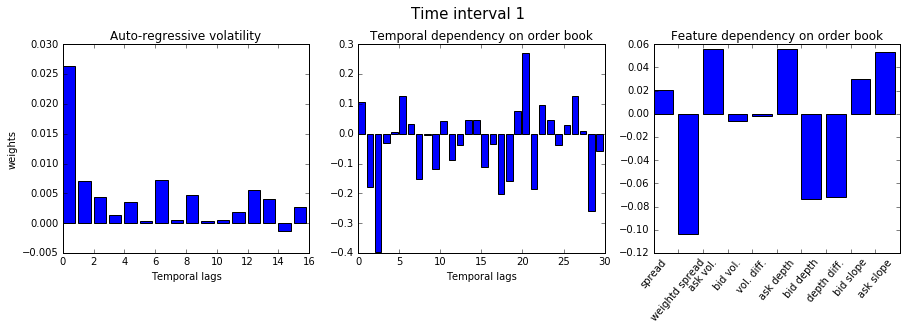

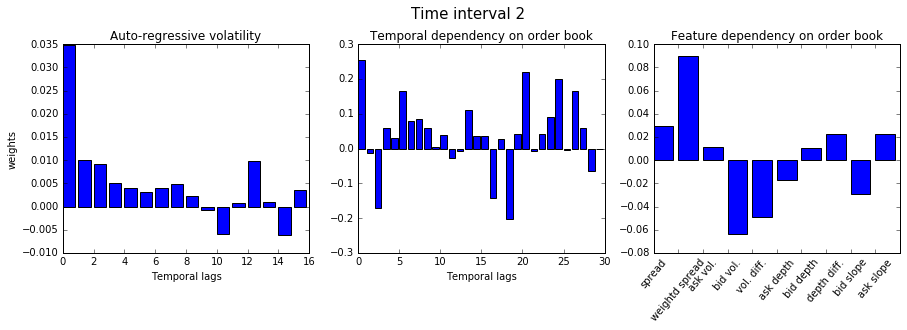

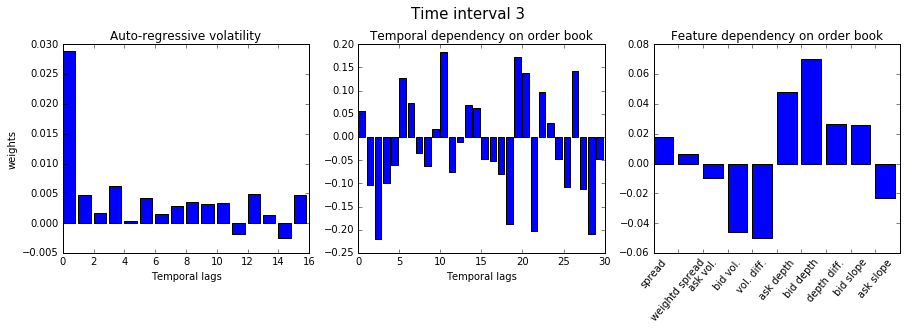

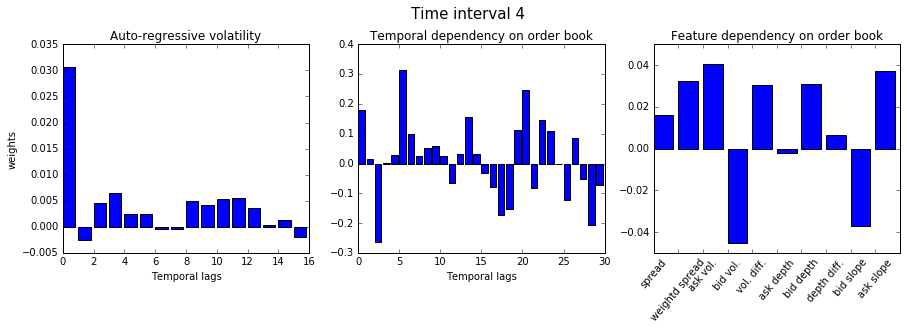

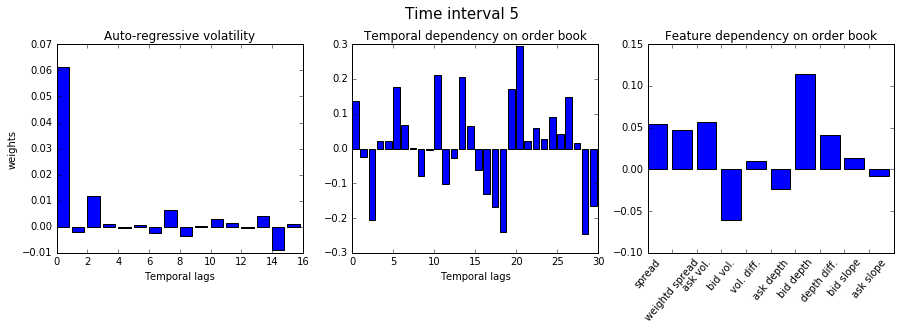

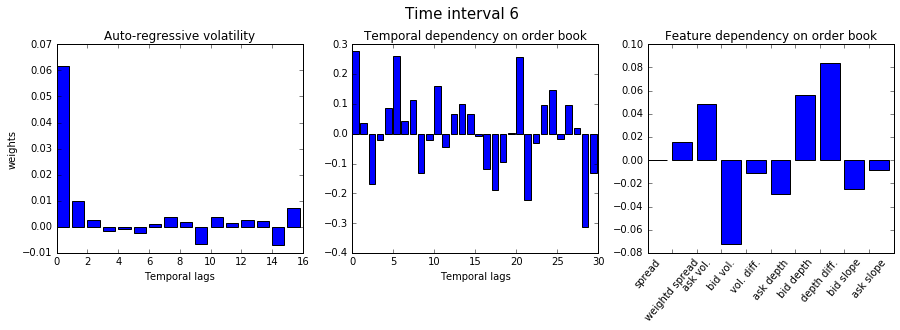

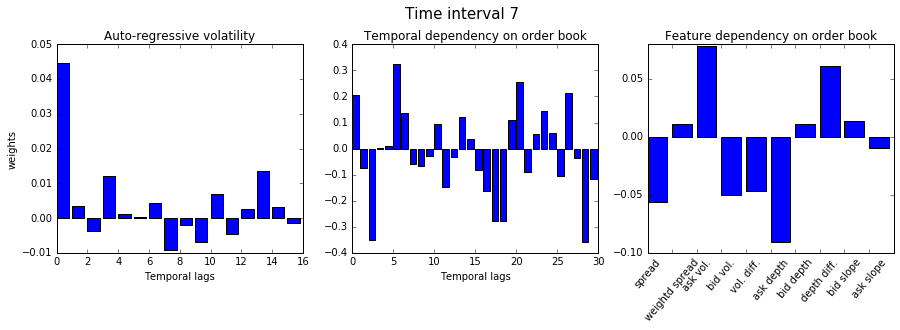

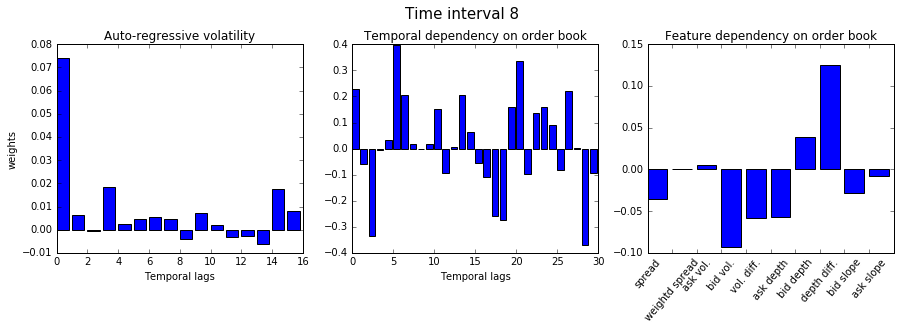

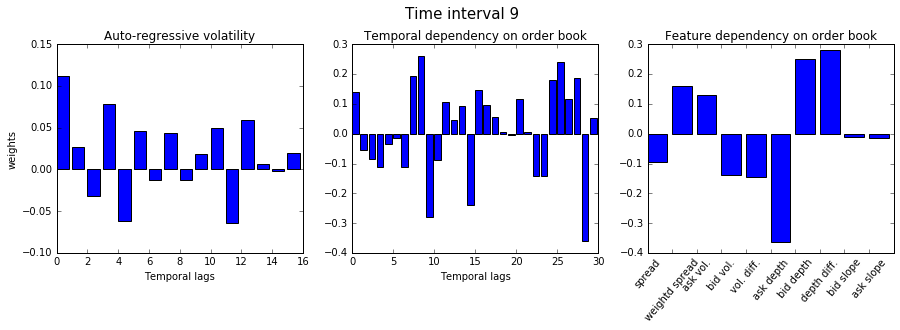

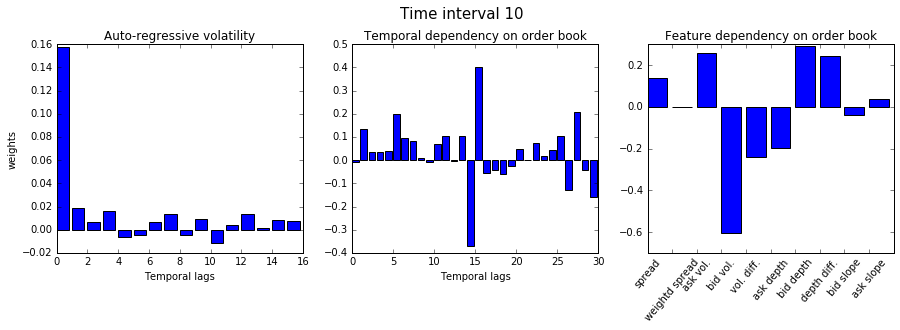

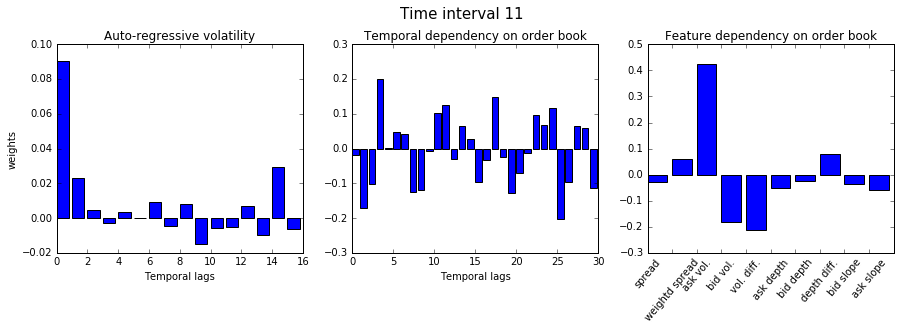

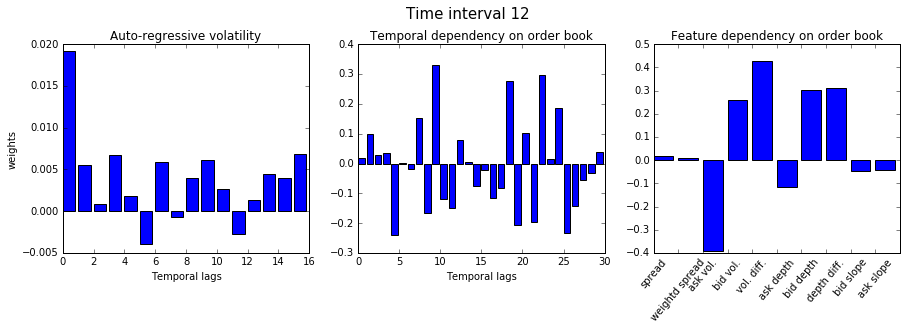

In [6]:
# parameter distribution of mixture prediction

# weight[0] vol temporal, [1] vol bias, [2] order book temporal, [3] order book feature, [4] bias 
    

for i in range(2,14):
    
    file_name = str(i) + weight_pre + post_dat
    tmp_weight = np.load(file_path + file_name)
    
    fig, ax_list = plt.subplots(1, 3, figsize=(15,4))
    
    fig.suptitle("Time interval " + str(i-1), fontsize = 15)
    
    ax_list[0].bar(range(len(np.squeeze(tmp_weight[0]))), np.flip(np.squeeze(tmp_weight[0]),0) )
    ax_list[0].set_title('Auto-regressive volatility')
    ax_list[0].set(xlabel='Temporal lags', ylabel='weights')
    
    ax_list[1].bar(range(len(np.squeeze(tmp_weight[2]))), np.flip(np.squeeze(tmp_weight[2]),0) )
    ax_list[1].set_title('Temporal dependency on order book')
    ax_list[1].set(xlabel='Temporal lags')
    
    ax_list[2].bar( range(len(np.squeeze(tmp_weight[3])) ), np.squeeze(tmp_weight[3]))
    ax_list[2].set_title('Feature dependency on order book')
    tmp_ind = range(len(np.squeeze(tmp_weight[3])))
    
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    plt.subplots_adjust(top=0.85)

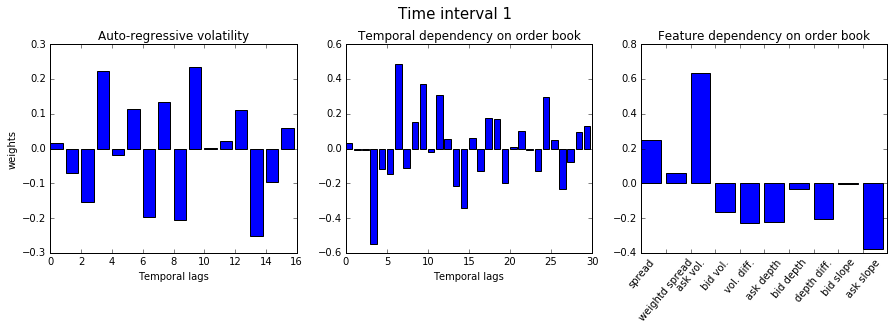

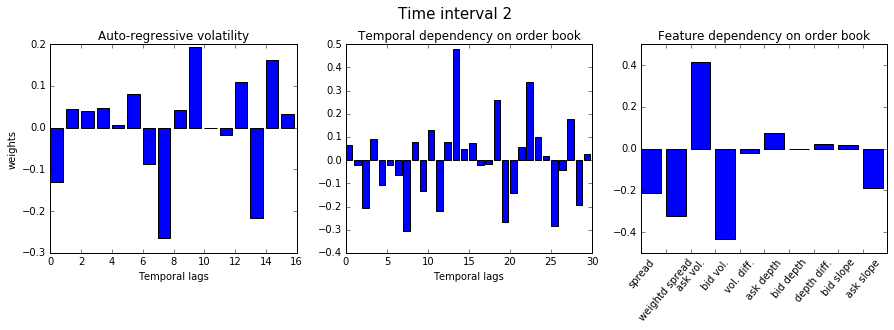

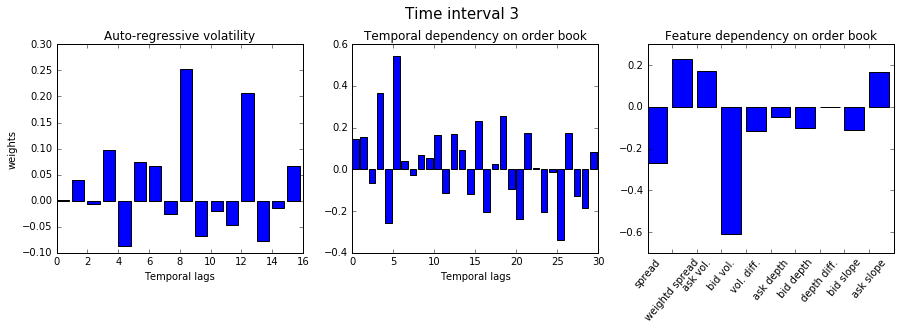

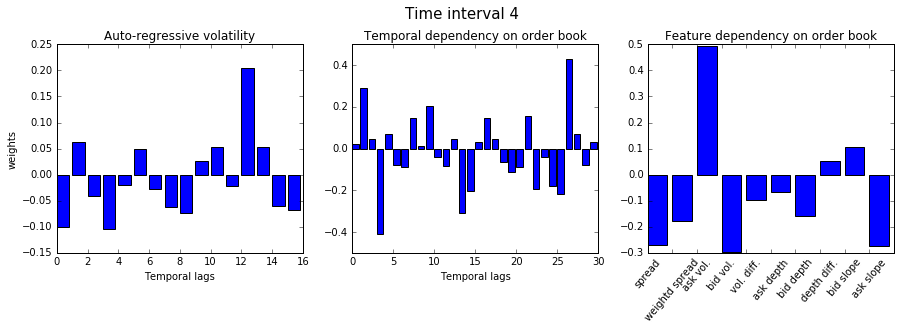

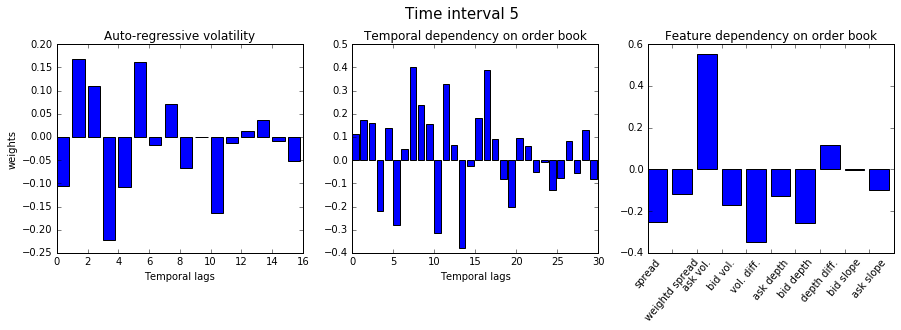

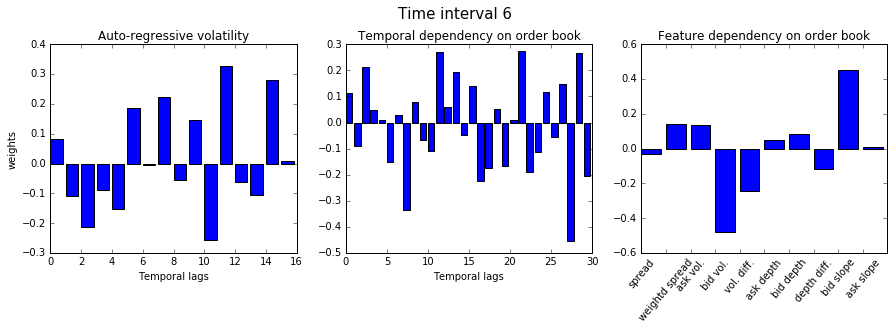

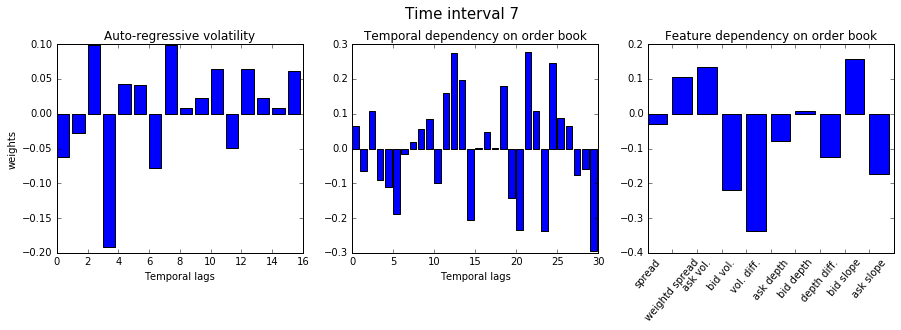

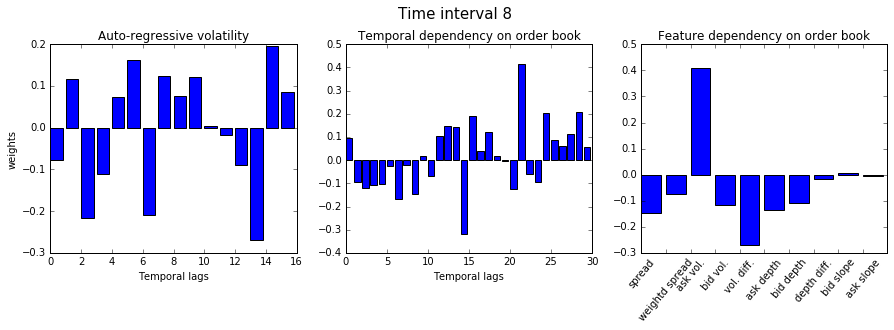

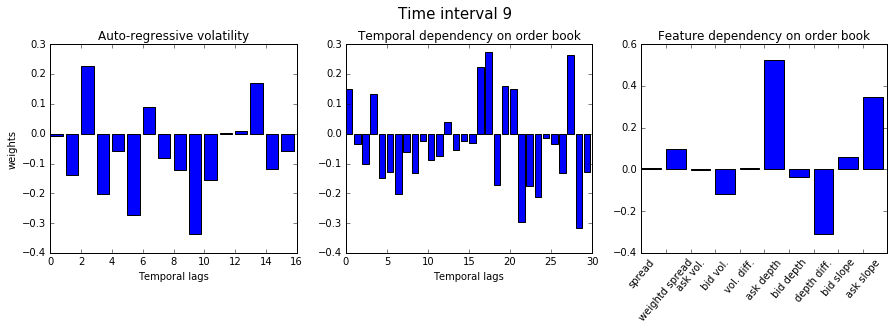

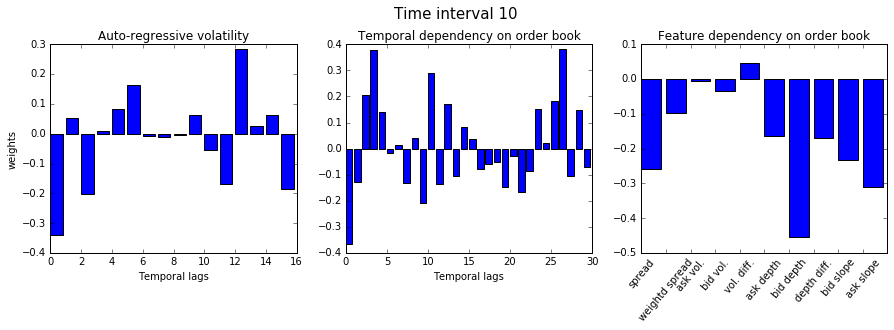

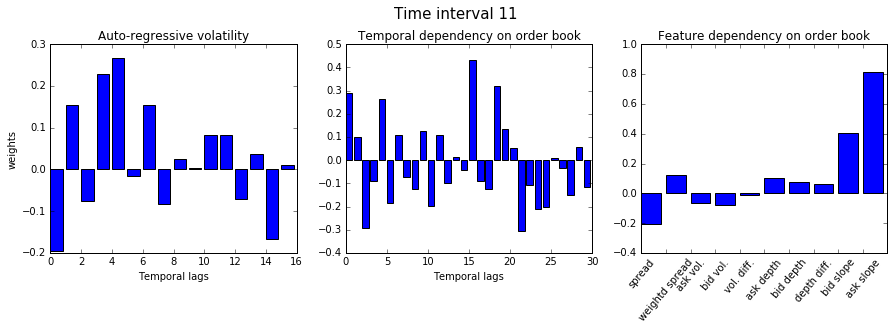

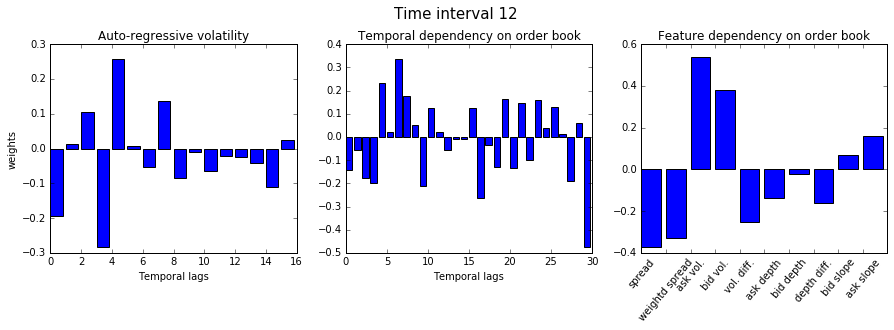

In [5]:
# parameter distribution of mixture weights

# weight[0] vol temporal, [1] vol bias, [2] order book temporal, [3] order book feature, [4] bias 
    

for i in range(2,14):
    
    file_name = str(i) + weight_gate + post_dat
    tmp_weight = np.load(file_path + file_name)
    
    fig, ax_list = plt.subplots(1, 3, figsize=(15,4))
    
    fig.suptitle("Time interval " + str(i-1), fontsize = 15)
    
    ax_list[0].bar(range(len(np.squeeze(tmp_weight[0]))), np.flip(np.squeeze(tmp_weight[0]),0) )
    ax_list[0].set_title('Auto-regressive volatility')
    ax_list[0].set(xlabel='Temporal lags', ylabel='weights')
    
    ax_list[1].bar(range(len(np.squeeze(tmp_weight[2]))), np.flip(np.squeeze(tmp_weight[2]),0) )
    ax_list[1].set_title('Temporal dependency on order book')
    ax_list[1].set(xlabel='Temporal lags')
    
    ax_list[2].bar( range(len(np.squeeze(tmp_weight[3])) ), np.squeeze(tmp_weight[3]))
    ax_list[2].set_title('Feature dependency on order book')
    tmp_ind = range(len(np.squeeze(tmp_weight[3])))
    
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    plt.subplots_adjust(top=0.85)


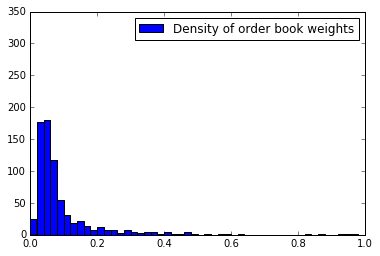

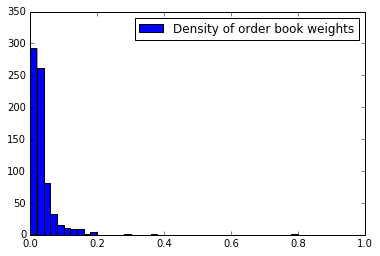

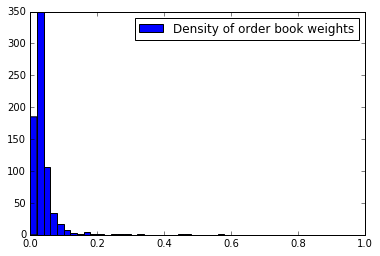

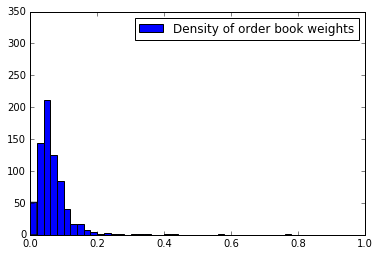

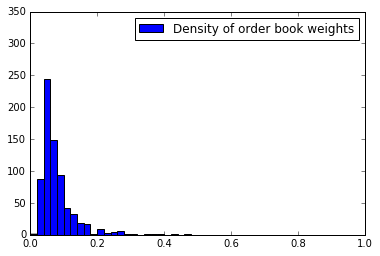

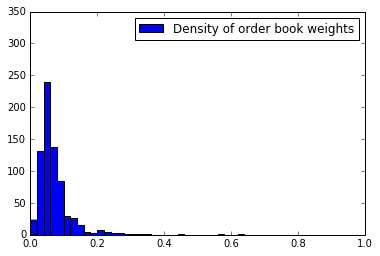

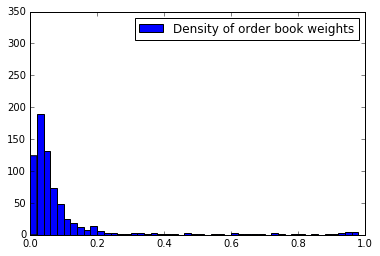

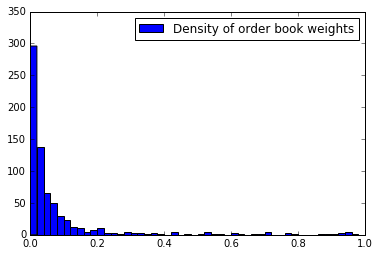

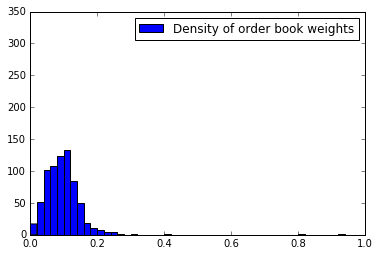

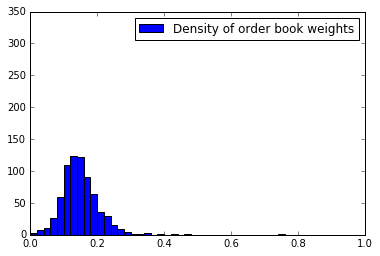

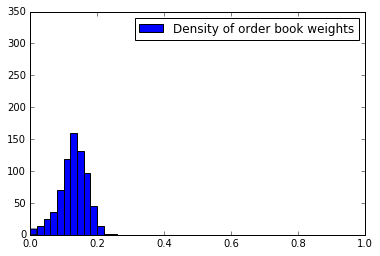

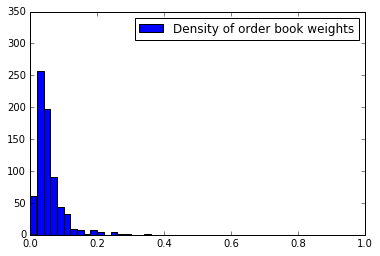

In [23]:
# mixture weight distribution

bin_bound = []
for i in range(50):
    bin_bound.append(i*0.02)

for i in range(2,14):
    
    tmp_rmse = []
    
    file_name = str(i) + '_' + gate_ts + postfix
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    
    fig, ax = plt.subplots()
    ax.hist(df['ob'], histtype='bar', bins = bin_bound,  label='Density of order book weights')
    ax.legend()
    ax.set_ylim(0,350)
    ax.set_xlim(0,1.0)
#     plt.title("Testing data")
    

In [655]:

def plot_prediction_truth(file_add, title, left, right, file_col_names):
    
    test_df = pd.read_csv(file_add, sep=',', names = file_col_names)
    
    fig, ax = plt.subplots()
    fig.set_size_inches( 18,7 )
    
    ax.plot(test_df['truth'].iloc[left:right], lw=2, label = 'True values' )
    ax.plot(test_df['pre'].iloc[left:right], lw=2, label = 'Prediction' )
    
#     ax.set_ylim(-.1, 1.)
    ax.legend()
    
    plt.title(title)
    
# residual investigation

def residual_cmparison_sig_test(models, file_path, prefix, file_col_names):
    
    postfix = '.txt'

    mix_ts = prefix + 'mix' + postfix
    mix_df = pd.read_csv( file_path + mix_ts, sep=',', names = file_col_names )
    mix_res = mix_df['truth'] - mix_df['pre']
    
    for i in models:
        
        tmp_path = prefix_ts + i + postfix
        tmp_df = pd.read_csv(file_path + tmp_path, sep=',', names = ['truth', 'pre'])
    
        tmp_res = tmp_df['truth'] - tmp_df['pre']
    
        print  i, ':', stats.ks_2samp( np.asarray(mix_res), np.asarray(tmp_res) )
        
def residual_test(models, file_path, prefix, file_col_names):
    
    postfix = '.txt'

    mix_ts = prefix + 'mix' + postfix
    mix_df = pd.read_csv( file_path + mix_ts, sep=',', names = file_col_names)
    mix_res = mix_df['truth'] - mix_df['pre']
    
    print 'mix', stats.kstest(np.asarray(mix_res), 'norm')
    
    print sm.stats.diagnostic.acorr_ljungbox(np.asarray(mix_res), lags = 5, boxpierce=False)[1]
    
#     print acf(  mix_res)  
#     print pacf( mix_res )
    
    for i in models:
        
        tmp_path = prefix_ts + i + postfix
        tmp_df = pd.read_csv(file_path + tmp_path, sep=',', names = ['truth', 'pre'])
    
        tmp_res = tmp_df['truth'] - tmp_df['pre']
    
        print i,':', stats.kstest(np.asarray(tmp_res), 'norm')
        
        print 'test for no autocorrelation: ', \
        sm.stats.diagnostic.acorr_ljungbox(np.asarray(tmp_res), lags = 5, boxpierce=False)[1]
        
        
def residual_plot(models, file_path, prefix, file_col_names):
    
    fig, ax = plt.subplots()
    fig.set_size_inches( 17,8 )
    
    postfix = '.txt'

    mix_ts = prefix + 'mix' + postfix
    mix_df = pd.read_csv( file_path + mix_ts, sep=',', names = file_col_names)
    mix_res = mix_df['truth'] - mix_df['pre']
    
    ax.plot(mix_res, lw=1, label = 'mixture')
    
#     for i in models:
        
#         tmp_path = prefix_ts + i + postfix
#         tmp_df = pd.read_csv(file_path + tmp_path, sep=',', names = ['truth', 'pre'])
    
#         tmp_res = tmp_df['truth'] - tmp_df['pre']
    
#         print i,':', stats.kstest(np.asarray(tmp_res), 'norm')
        
#         ax.plot( tmp_res, lw = 1, label = i )
    
    ax.legend( loc=0)
    ax.set_ylim(-1.5, 1.5)
    
def mixture_weight_condition_on_vol( gate, y, lower, upper ):
   
    tmpv = []
    tmpob= []
    gate = np.asarray(gate)
    for i in range(1,len(gate)):
        tmp_v =  gate[i][0]
        tmp_ob = gate[i][1]
        
        if y[i] >=lower and y[i]<=upper:
            tmpv.append(tmp_v)
            tmpob.append(tmp_ob)
    
    print lower, upper, " : ", len(tmpv), mean(tmpv), mean(tmpob),' p-value: ', sp.stats.ttest_ind(tmpv,tmpob)[1]


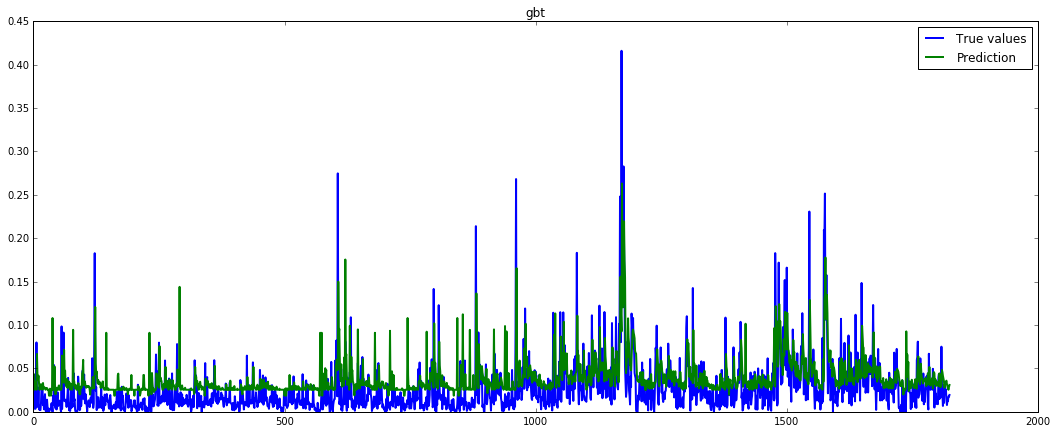

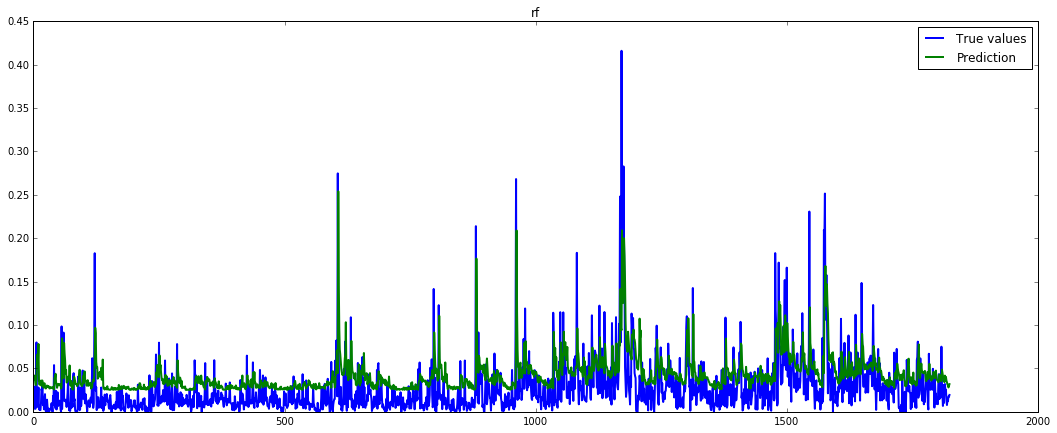

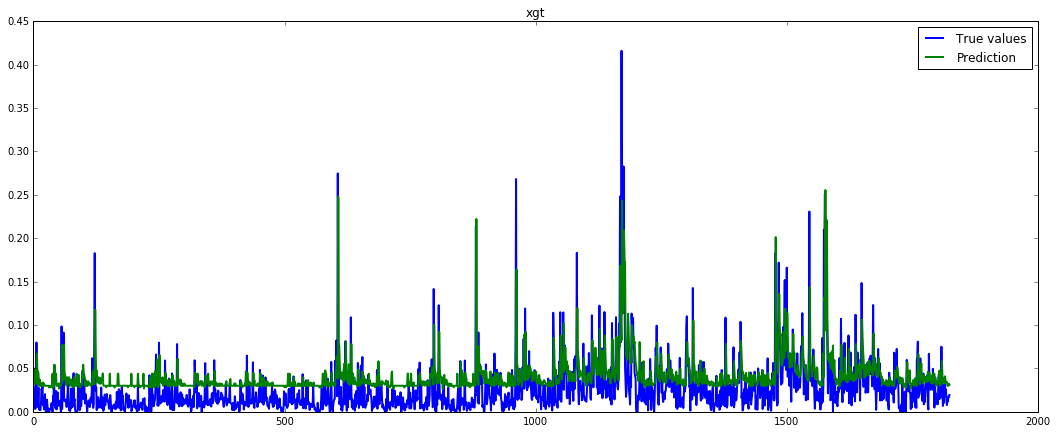

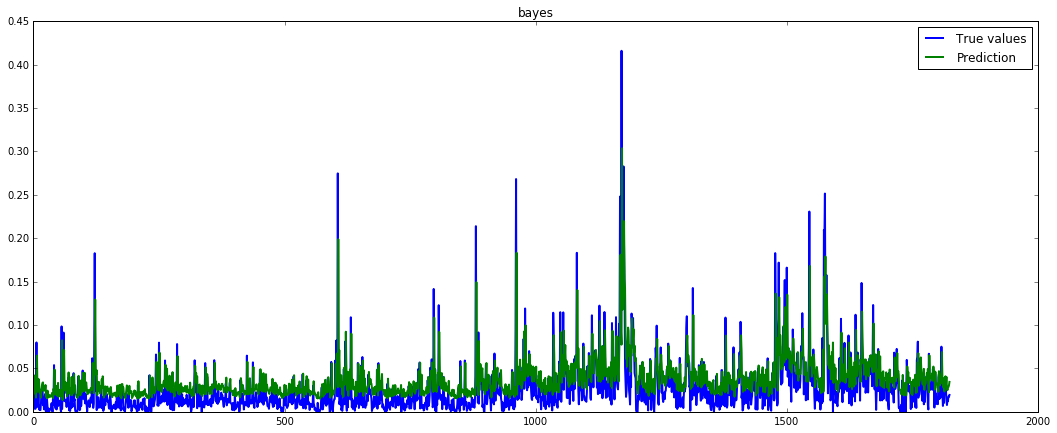

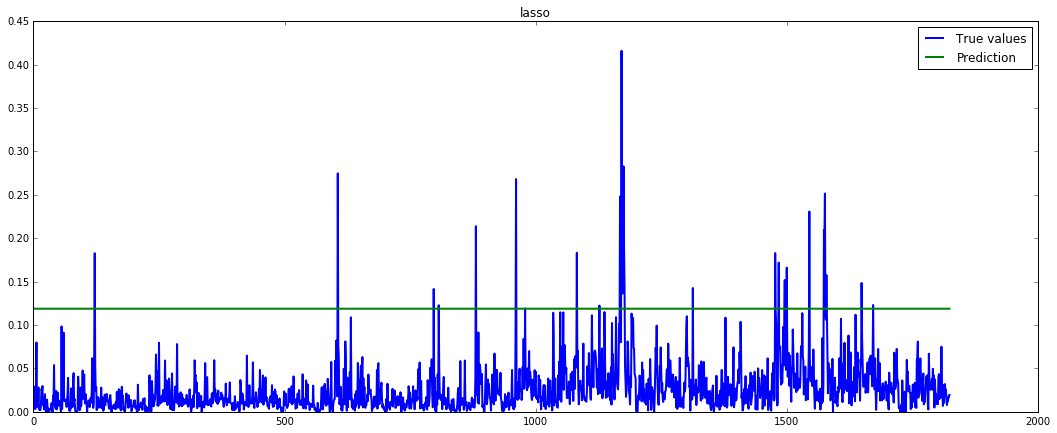

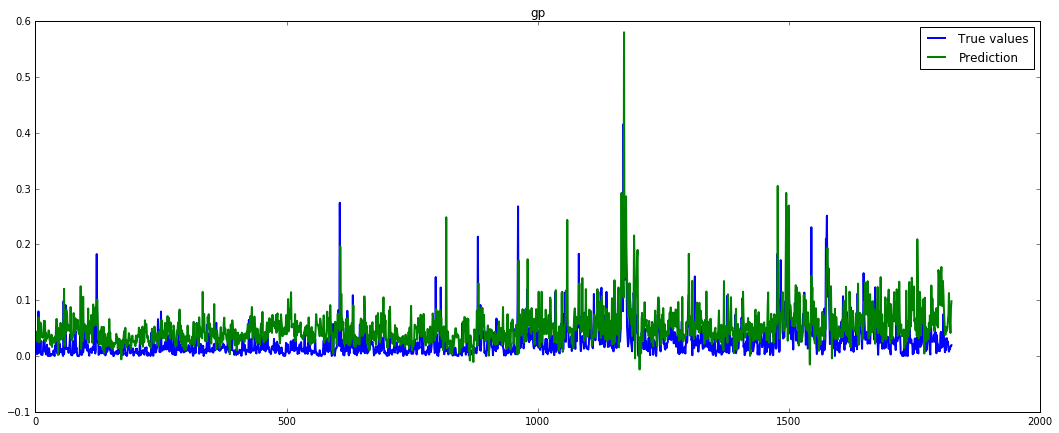

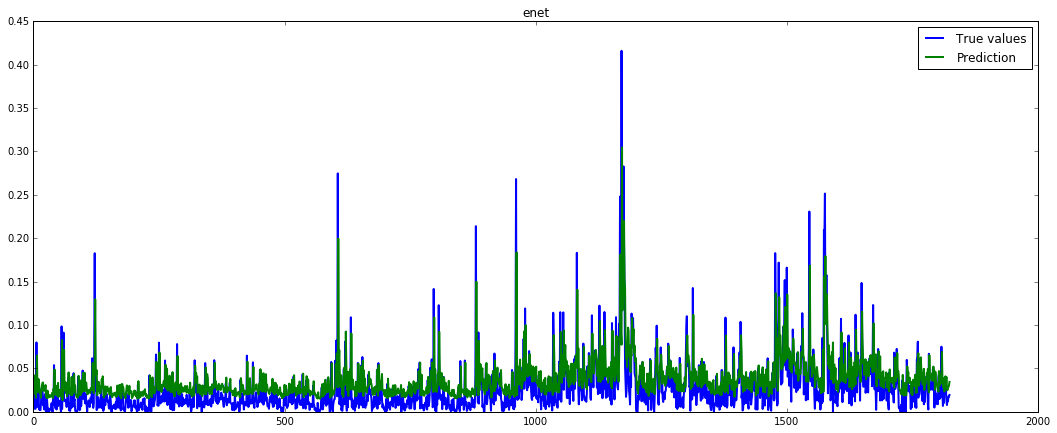

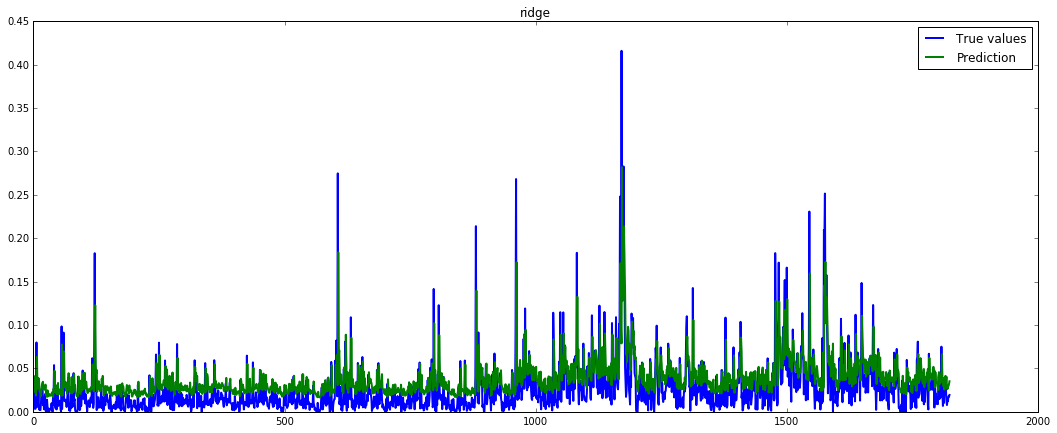

In [477]:
name_format = ['truth', 'pre', 'pre_v', 'pre_b']
models = ['gbt', 'rf', 'xgt', 'bayes', 'lasso', 'gp', 'enet', 'ridge']
#, 'arima'
#'arimax'
postfix = '.txt'

for i in models:
    plot_prediction_truth(file_path + 'pytest_' + i + postfix , i, 0, 3000, ['truth', 'pre'])


0.0264508318735


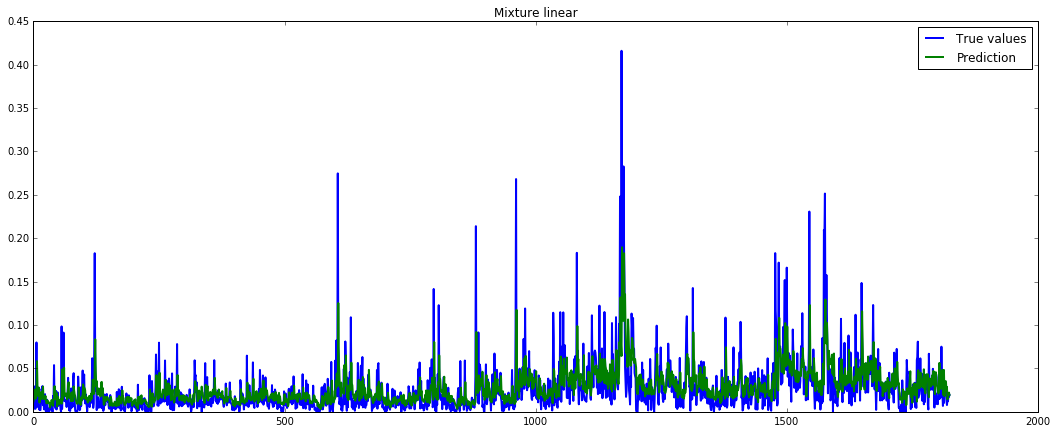

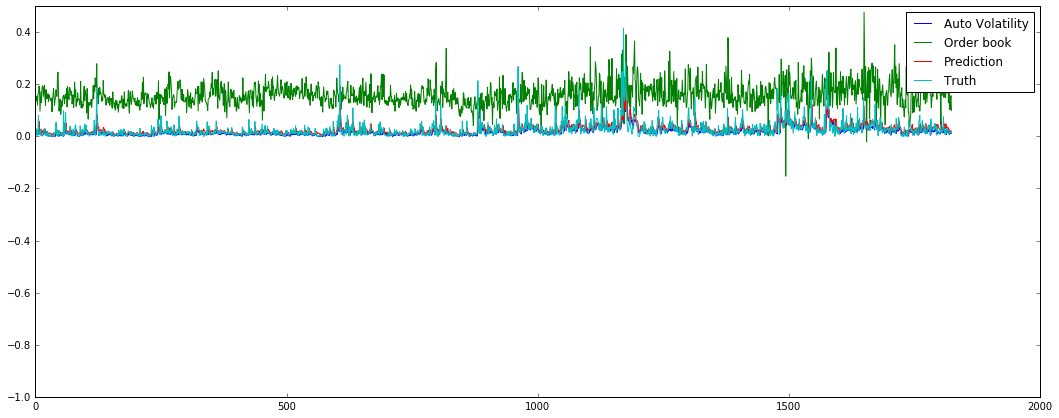

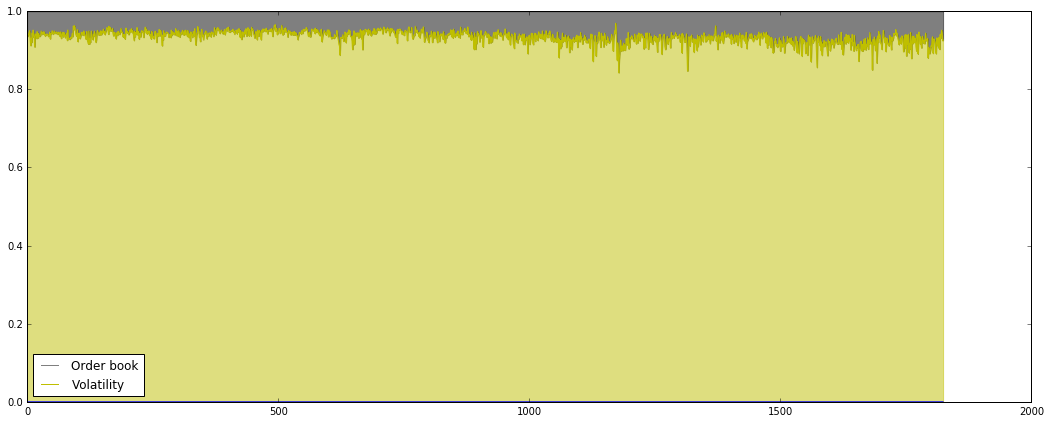

In [680]:
#---- TESTING ----

tmpdf = pd.read_csv('../bt_results/res/pytest_mix.txt', sep=',', names = ['truth', 'pre', 'pre_v', 'pre_b'])
tmp = tmpdf['pre'] - tmpdf['truth']
print sqrt(mean(tmp*tmp))

gate_tr = pd.read_csv('../bt_results/res/gate_train.txt',sep=',', names = ['vol','ob'])
gate_ts = pd.read_csv('../bt_results/res/gate_test.txt', sep=',', names = ['vol','ob'])

plot_l = 0
plot_r = 3000
plot_prediction_truth('../bt_results/res/pytest_mix.txt', 'Mixture linear', plot_l, plot_r, name_format)
tmp_gate =  np.asarray(gate_ts.iloc[plot_l:plot_r])

# for i in range(3, len(tmp_gate)-3):
#      tmp_gate[i][0] = mean([tmp_gate[j][0] for j in range(i+1, i+2)])

mix_pre_df = pd.read_csv(file_path + 'pytest_mix.txt', sep=',', names = name_format)

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )
    
ax.plot(mix_pre_df['pre_v'].iloc[plot_l:plot_r], label = 'Auto Volatility')
ax.plot(mix_pre_df['pre_b'].iloc[plot_l:plot_r], label = 'Order book')
ax.plot(mix_pre_df['pre'].iloc[plot_l:plot_r], label = 'Prediction')
ax.plot(mix_pre_df['truth'].iloc[plot_l:plot_r], label = 'Truth')

ax.set_ylim(-1, 0.5)
ax.legend()

X = range(len(tmp_gate))
Y =  [1.0 for i in tmp_gate ]
Y1 = [i[0] for i in tmp_gate]
Y2 = [0.0 for i in tmp_gate]

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

ax.plot(Y, label = 'Order book', color='k', alpha=.5)
ax.plot(Y1,label = 'Volatility', color = 'y')
ax.plot(Y2,)
plt.fill_between(X, Y, Y1, color='k',alpha=.5)
plt.fill_between(X, Y1,Y2, color='y',alpha=.5)

ax.legend(loc=0)

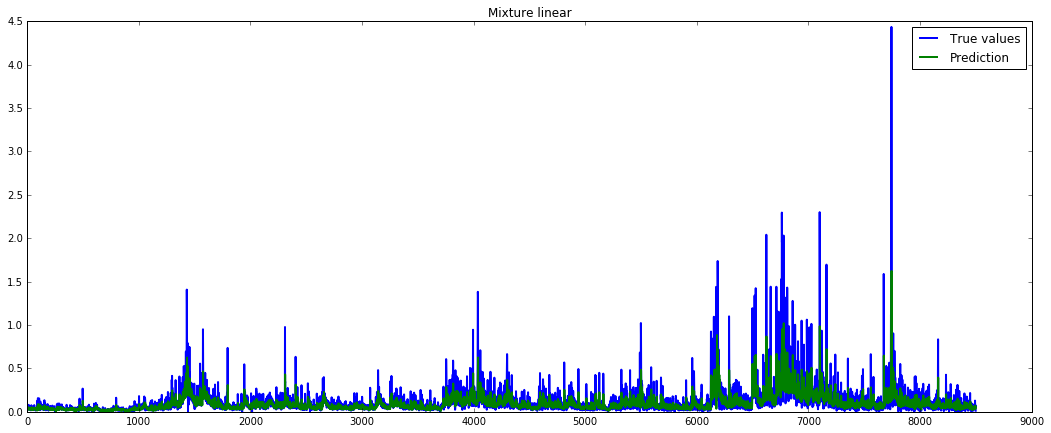

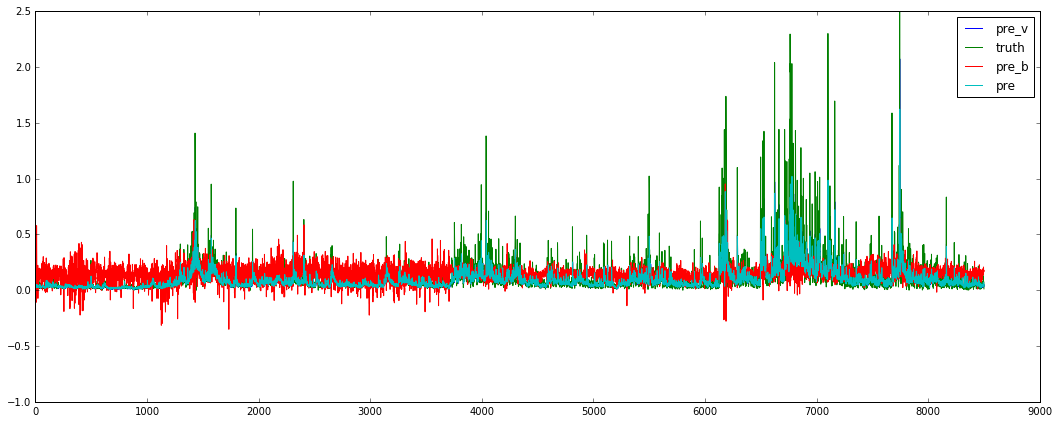

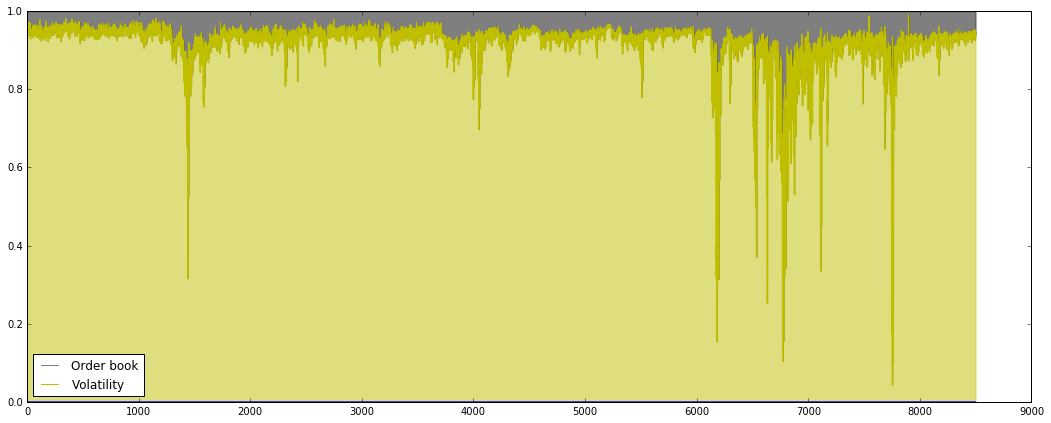

In [681]:
# TRAINING

gate_tr = pd.read_csv('../bt_results/res/gate_train.txt',sep=',', names = ['vol','ob'])
gate_ts = pd.read_csv('../bt_results/res/gate_test.txt', sep=',', names = ['vol','ob'])

plot_l = 0
plot_r = 10000
plot_prediction_truth('../bt_results/res/pytrain_mix.txt', 'Mixture linear', plot_l, plot_r, name_format)

tmp_gate =  np.asarray(gate_tr.iloc[plot_l:plot_r])

# for i in range(3, len(tmp_gate)-3):
#      tmp_gate[i][0] = mean([tmp_gate[j][0] for j in range(i+1, i+2)])

mix_pre_df = pd.read_csv(file_path + 'pytrain_mix.txt', sep=',', names = name_format)

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

ax.plot(mix_pre_df['pre_v'].iloc[plot_l:plot_r], label = 'pre_v')
ax.plot(mix_pre_df['truth'].iloc[plot_l:plot_r], label = 'truth')
ax.plot(mix_pre_df['pre_b'].iloc[plot_l:plot_r], label = 'pre_b')
ax.plot(mix_pre_df['pre'].iloc[plot_l:plot_r], label = 'pre')
# ax.plot(mix_pre_df['truth'].iloc[plot_l:plot_r], label = 'Truth')

ax.set_ylim(-1, 2.5)
ax.legend()

X = range(len(tmp_gate))
Y =  [1.0 for i in tmp_gate ]
Y1 = [i[0] for i in tmp_gate]
Y2 = [0.0 for i in tmp_gate]

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

ax.plot(Y, label = 'Order book', color='k', alpha=.5)
ax.plot(Y1,label = 'Volatility', color = 'y')
ax.plot(Y2,)
plt.fill_between(X, Y, Y1, color='k',alpha=.5)
plt.fill_between(X, Y1,Y2, color='y',alpha=.5)

ax.legend(loc=0)

In [ ]:
# ---- load results ----

gate_tr = np.asarray( pd.read_csv('../bt_results/res/gate_train.txt',sep=',', names = ['vol','ob']) )
gate_ts = np.asarray( pd.read_csv('../bt_results/res/gate_test.txt', sep=',', names = ['vol','ob']) )

tr_df = pd.read_csv(file_path + 'pytrain_mix.txt', sep=',', names = name_format)
ts_df = pd.read_csv(file_path + 'pytest_mix.txt', sep=',', names = name_format)

xtrain = np.load("../dataset/bitcoin/training_data/xtrain_"+file_postfix+".dat")
xtest  = np.load("../dataset/bitcoin/training_data/xtest_" +file_postfix+".dat")
ytrain = np.load("../dataset/bitcoin/training_data/ytrain_"+file_postfix+".dat")
ytest  = np.load("../dataset/bitcoin/training_data/ytest_" +file_postfix+".dat")

x_orig  = np.load("../dataset/bitcoin/training_data/xtrain_orig.dat")

steps = np.shape(x_orig[0][1])[0]
num_ft = np.shape(x_orig[0][1])[1]
print steps, num_ft

dta_v =   np.asarray( [i[0] for i in xtrain] )
dta_distr = np.asarray( [i[1] for i in xtrain] )
print np.shape(dta_v), np.shape(dta_distr)

ylimits = [[0,10], [0,10], [0,200], [0,250], [-100, 100],\
[0,1500], [0,2500], [-1000, 1000], [0, 350], [0, 450]]

In [695]:
# ---- conditional error evaluation ----

# gate interval: error of mixture, errors of baseline models

models = ['gbt', 'rf', 'xgt', 'bayes', 'lasso', 'gp', 'enet', 'ridge']
#, 'arima'
#'arimax'
#'str', 'strx', 
# , 'garch', 'egarch'

def err_conditional_on_gate( gate_range, gate, models, path, prefix ):
    
    pos = []
    for i in range(len(gate)):
        if gate[i][1]>gate_range[0] and gate[i][1]<gate_range[1]:
            pos.append(i)
    num = len(pos)
    print num
    
    postfix = '.txt'
    mix_name = prefix + 'mix' + postfix
    mix_df = pd.read_csv( path + mix_name, sep=',', names = ['truth', 'pre', 'pre_v', 'pre_b'] )
    
    mix_arr = np.asarray(mix_df[['truth','pre']])
    mix_pos = mix_arr[pos]
    print len(mix_pos)
    
    tr = np.transpose(mix_pos,[1,0])[0]
    pre = np.transpose(mix_pos,[1,0])[1]
    
    print 'mix', sqrt(mean((tr-pre)*(tr-pre)))

    for i in models:
        
        print i
        
        file_name = prefix + i + postfix
        tmp_df = pd.read_csv(path + file_name, sep=',', names = ['truth', 'pre'])
        
        tmp_arr = np.asarray(tmp_df[['truth','pre']])
        tmp_pos = tmp_arr[pos]
#         print len(mix_pos)
    
        tr = np.transpose(tmp_pos,[1,0])[0]
        pre = np.transpose(tmp_pos,[1,0])[1]
        print  sqrt(mean((tr-pre)*(tr-pre)))


In [699]:
err_conditional_on_gate([0.1,0.2], gate_ts, models, file_path, 'pytest_' )

66
66
mix 0.0392070458333
gbt
0.0379757645834
rf
0.0411460424834
xgt
0.0392122752251
bayes
0.0374348850393
lasso
0.0867054410996
gp
0.0429140645675
enet
0.0374321430095
ridge
0.0376064938608


mix 1.94738343441
gbt 2.27894751633
rf 2.54839704734
xgt 2.4679026984
bayes 1.97973634277
lasso 10.2159777322
gp 1.766967305
enet 1.97577096938
ridge 2.07111448011


In [685]:
# visualize patterns of mixtures

def pattern_conditional_on_gate( gate_range, gate, dta_v, dta_distr, ylimits, ydata ):
    pos = []
    for i in range(len(gate)):
        if gate[i][1]>gate_range[0] and gate[i][1]<gate_range[1]:
            pos.append(i)
    num = len(pos)
    print num
    
    
    np.random.shuffle(pos)
    if num<100:
        cnt_sample = num
    else:
        cnt_sample = 100
        
    
    tmplen   = 10
    subseq_y = []
    for i in range(cnt_sample):
        if pos[i] + tmplen < len(ydata):
            subseq_y.append( ydata[pos[i]:pos[i]+tmplen] )
    
    subseq_y = np.asarray(subseq_y)
    vsample = dta_v[pos[:cnt_sample]]
    dsample = dta_distr[pos[:cnt_sample]]
    print np.shape(vsample), np.shape(dsample)


    # plot auto-regressive and subsequent volatility
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
    # fig.set_size_inches( 18,7 )
    ax1.boxplot(vsample);
    ax1.set_ylim(0,5.0)
    
    ax2.boxplot(subseq_y);
    ax2.set_ylim(0,5.0)
    
    
    # plot order book feature patterns
    trans_dsample = np.transpose(dsample, [2, 0, 1])

    fig, ax_list = plt.subplots(2, 5, figsize=(19,10))
    for i in range(2):
        for j in range(5):
            
            feature_idx = i*5+j
            step_data = []

            ax_list[i][j].boxplot( trans_dsample[feature_idx] )
            ax_list[i][j].set_ylim( ylimits[feature_idx][0], ylimits[feature_idx][1] )

# ----



30 10
(8500, 16) (8500, 30, 10)


In [654]:
pattern_conditional_on_gate( [0.0, 0.2], gate_tr, dta_v, dta_distr, ylimits, ytrain )

pattern_conditional_on_gate( [0.2, 0.4], gate_tr, dta_v, dta_distr, ylimits, ytrain )

pattern_conditional_on_gate( [0.4, 0.6], gate_tr, dta_v, dta_distr, ylimits, ytrain )

pattern_conditional_on_gate( [0.6, 1.0], gate_tr, dta_v, dta_distr, ylimits, ytrain )

In [ ]:
def errorfill(x, y, yerr, interval, color=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color)
    ax.set_ylim(interval)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)

In [283]:
def mixture_gate_condition_on_vol( pre, gate, y, lower, upper ):
   
    tmpv = []
    tmpob= []

    gatev = []
    gateob= []
    
    gate = np.asarray(gate)
    pre = np.asarray(pre)
    
    gateup = 0
    
    for i in range(1,len(gate)):
        tmp_v =  pre[i][2]
        tmp_ob = pre[i][3]
        
        g_v =  gate[i][0]
        g_ob = gate[i][1]
        
        if pre[i][0] >=lower and pre[i][0]<=upper and  pre[i][0] < pre[i-1][0] :
            tmpv.append(tmp_v)
            tmpob.append(tmp_ob)
            
            gatev.append(g_v)
            gateob.append(g_ob)
            
            if g_ob < gate[i-1][1]:
                gateup+=1
            
    
    print lower, upper, " : ", len(tmpv), mean(tmpv), mean(gatev), \
    mean(tmpob), mean(gateob), gateup/(len(gateob)+1e-10), gateup, len(gateob) 
#     ' p-value: ', sp.stats.ttest_ind(tmpv,tmpob)[1]

mix_pre_train = pd.read_csv(file_path + 'pytrain_mix.txt', sep=',', names = name_format)
mix_pre_test  = pd.read_csv(file_path + 'pytest_mix.txt',  sep=',', names = name_format)


print 'Training:'
for i in range(0,60):
    mixture_gate_condition_on_vol( mix_pre_train, gate_tr, ytrain, 0.01*i, 0.01*(i+1) )
    
    
print '\nTesting:'
for i in range(1,50):
    mixture_gate_condition_on_vol( mix_pre_test, gate_ts, ytest, 0.01*i, 0.01*(i+1) )

Training:
0.0 0.01  :  45 0.0541385329432 0.908192927308 -0.0883380864643 0.0918070665949 0.555555555554 25 45
0.01 0.02  :  288 0.0431761166288 0.936211018306 -0.171541982363 0.0637889801876 0.541666666666 156 288
0.02 0.03  :  500 0.0560065115988 0.926711458325 -0.112835773084 0.0732885434028 0.516 258 500
0.03 0.04  :  570 0.067134998595 0.914050471574 -0.0906714352175 0.0859495296777 0.501754385965 286 570
0.04 0.05  :  503 0.0805387560641 0.905677115882 -0.0722855504595 0.0943228833445 0.506958250497 255 503
0.05 0.06  :  366 0.101437634498 0.899042178617 -0.0514684366011 0.100957824812 0.551912568306 202 366
0.06 0.07  :  317 0.117937034072 0.875692636997 -0.0185845213875 0.124307362361 0.501577287066 159 317
0.07 0.08  :  272 0.131102655439 0.870749372222 -0.00581833588726 0.129250624997 0.485294117647 132 272
0.08 0.09  :  200 0.145748059116 0.859134736508 0.0185963538941 0.140865263102 0.51 102 200
0.09 0.1  :  175 0.163224634486 0.849291757856 0.0104665811147 0.150708245708 0

0.0 4.43378288192
0.278353388213 0.292948328338


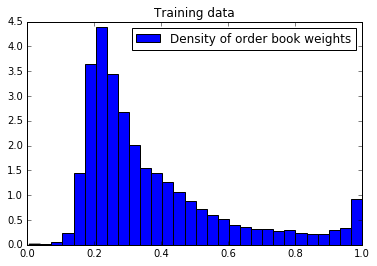

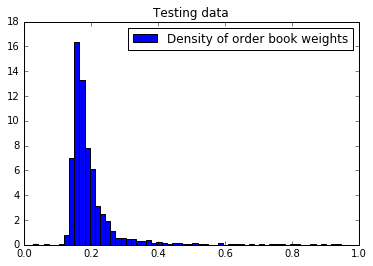

In [149]:
# conditional distribution of mixture weights on discrete volatility ranges 

print min(ytrain), max(ytrain)
print min(ytest), max(ytest)


fig, ax = plt.subplots()
ax.hist(gate_tr['ob'], histtype='bar', bins=30, normed= 1, label='Density of order book weights')
ax.legend()
# ax.set_ylim(0,10)
ax.set_xlim(0,1.0)
plt.title("Training data")
# ax.title("Training data")

fig, ax = plt.subplots()
ax.hist(gate_ts['ob'], histtype='bar', bins=60, normed= 1, label='Density of order book weights')
ax.legend()
# ax.set_ylim(0,10)
ax.set_xlim(0,1.0)
plt.title("Testing data")
# ax.title("Training data")


-- residual of mixture comopared with baseline test:
gbt : Ks_2sampResult(statistic=0.64329411764705879, pvalue=0.0)
rf : Ks_2sampResult(statistic=0.63388235294117645, pvalue=0.0)
xgt : Ks_2sampResult(statistic=0.68282352941176472, pvalue=0.0)
bayes : Ks_2sampResult(statistic=0.61317647058823521, pvalue=0.0)
lasso : Ks_2sampResult(statistic=0.89129411764705879, pvalue=0.0)
gp : Ks_2sampResult(statistic=0.51435294117647057, pvalue=1.9690349631162664e-246)
enet : Ks_2sampResult(statistic=0.61223529411764699, pvalue=0.0)
ridge : Ks_2sampResult(statistic=0.61599999999999999, pvalue=0.0)
str : Ks_2sampResult(statistic=0.79152941176470593, pvalue=0.077271766236952352)
strx : Ks_2sampResult(statistic=0.92752941176470594, pvalue=0.022949622348945969)
garch : Ks_2sampResult(statistic=0.81270588235294117, pvalue=0.0)
egarch : Ks_2sampResult(statistic=0.77882352941176469, pvalue=0.0)

-- residual normality test:
mix KstestResult(statistic=0.45822218803510578, pvalue=0.0)
[  4.90381949e-01   8.49

/home/guo/.local/lib/python2.7/site-packages/statsmodels/sandbox/stats/diagnostic.py:295: RuntimeWarning: divide by zero encountered in divide
  acf2norm = acfx[1:maxlag+1]**2 / (nobs - np.arange(1,maxlag+1))


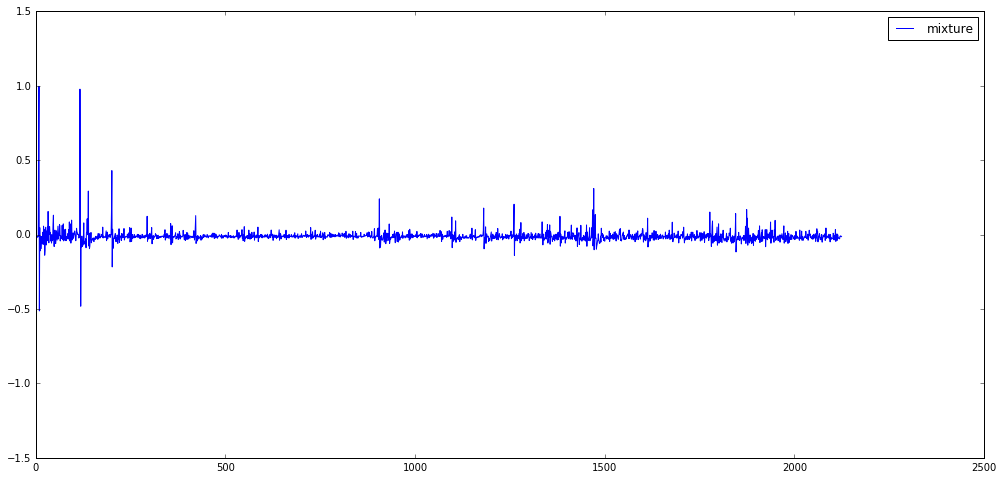

In [108]:
residual_plot(models, file_path, prefix_ts, name_format)
# plot_l = 0
# plot_r = 2000

# plot_prediction_truth('../bt_results/res/pytest_bayes.txt', 'Bayes regression', plot_l, plot_r)
# plot_prediction_truth('../bt_results/res/pytest_enet.txt', 'Elastic net', plot_l, plot_r)
# plot_prediction_truth('../bt_results/res/pytest_rf.txt', 'Random forest', plot_l, plot_r)
# plot_prediction_truth('../bt_results/res/pytest_gbt.txt', 'Gradient boostet tree', plot_l, plot_r)

# plot_prediction_truth('res/pytest.txt', 'Mixture linear', plot_l, plot_r)

In [ ]:
'''
# backup

#---- log sq ----

test_df = pd.read_csv('res/pytest.txt',    sep=',', names = ['pred', 'true'])
gate_tr = pd.read_csv('res/gate_train.txt',sep=',', names = ['vol','ob'])
gate_ts = pd.read_csv('res/gate_test.txt', sep=',', names = ['vol','ob'])
print test_df.shape, gate_tr.shape, gate_ts.shape

plot_horizon = 20
plot_prediction_truth('res/pytest.txt', 'Mixture linear', plot_horizon)
tmp_gate =  np.asarray(gate_ts.iloc[:plot_horizon])

# for i in range(3, len(tmp_gate)-3):
#      tmp_gate[i][0] = mean([tmp_gate[j][0] for j in range(i-1, i+1)])

X = range(len(tmp_gate))
Y =  [1.0 for i in tmp_gate ]
Y1 = [i[0] for i in tmp_gate]
Y2 = [0.0 for i in tmp_gate]

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

ax.plot(Y, label = 'Order book', color='k', alpha=.5)
ax.plot(Y1,label = 'Volatility', color = 'y')
ax.plot(Y2,)
plt.fill_between(X, Y, Y1, color='k',alpha=.5)
plt.fill_between(X, Y1,Y2, color='y',alpha=.5)

ax.legend(loc=0)

#---- sq ----

test_df = pd.read_csv('../bt_results/res/pytest.txt',    sep=',', names = ['pred', 'true'])
gate_tr = pd.read_csv('../bt_results/res/gate_train.txt',sep=',', names = ['vol','ob'])
gate_ts = pd.read_csv('../bt_results/res/gate_test.txt', sep=',', names = ['vol','ob'])
print test_df.shape, gate_tr.shape, gate_ts.shape

plot_l = 0
plot_r = 250

plot_prediction_truth('../bt_results/res/pytest.txt', 'Mixture linear', plot_l, plot_r)
tmp_gate =  np.asarray(gate_ts.iloc[plot_l:plot_r])

#for i in range(3, len(tmp_gate)-3):
 #    tmp_gate[i][0] = mean([tmp_gate[j][0] for j in range(i-1, i+1)])

X = range(len(tmp_gate))
Y =  [1.0 for i in tmp_gate ]
Y1 = [i[0] for i in tmp_gate]
Y2 = [0.0 for i in tmp_gate]

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

ax.plot(Y, label = 'Order book', color='k', alpha=.5)
ax.plot(Y1,label = 'Volatility', color = 'y')
ax.plot(Y2,)
plt.fill_between(X, Y, Y1, color='k',alpha=.5)
plt.fill_between(X, Y1,Y2, color='y',alpha=.5)

ax.legend(loc=0)